# Lecture 10: Cavity-QED in the dispersive regime

Author: J. R. Johansson (robert@riken.jp), http://dml.riken.jp/~rob/

The latest version of this [IPython notebook](http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html) lecture is available at [http://github.com/jrjohansson/qutip-lectures](http://github.com/jrjohansson/qutip-lectures).

The other notebooks in this lecture series are indexed at [http://jrjohansson.github.com](http://jrjohansson.github.com).

In [775]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import *

In [776]:
from qutip import *

# Introduction

A qubit-resonator system can described by the Hamiltonian

$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2} \omega_q \sigma_z + g (a^\dagger + a) \sigma_x$

where $\omega_r$ and $\omega_q$ are the the bare frequencies of the resonator and qubit, respectively, and where $g$ is the dipole interaction strength. 

The dispersive regime occurs when the resonator and qubit is far off resonance, $\Delta \gg g$, where $\Delta = \omega_r-\omega_q$ is the detuning between the resonator and the qubit (for example $\omega_r \gg \omega_q$).

In the dispersive regime the system can be described by an effective Hamiltonian on the form

$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2}\omega_q \sigma_z + \chi (a^\dagger a  + 1/2) \sigma_z$

where $\chi = g^2/\Delta$ . We can view the last term as a correction of the resonator frequency that depends on the qubit state, or a correction to the qubit frequency that depends on the resonator state.

In a beautiful experiment by D. I. Schuster et al., the dispersive regime was used to resolving the photon number states of a microwave resonator by monitoring a qubit that was coupled to the resonator. This notebook shows how to simulate this kind of system numerically in QuTiP.

### References

 * [D. I. Schuster et al., Resolving photon number states in a superconducting circuit, Nature 445, 515 (2007)](http://dx.doi.org/10.1038/nature05461)

## Parameters

In [777]:
N = 20

wr = 2.0 * 2 * pi      # resonator frequency
wq = 3.0 * 2 * pi      # qubit frequency
chi = 0.025 * 2 * pi   # parameter in the dispersive hamiltonian

wq = 2*pi*6.2815      # Energy of the 2-level system (GHz)
wr = 2*pi*8.3056      # Resonator freq
chi= 2*pi*1.97e-3     # qubit-storage coupling strength

t_fac = wq/(2*pi*3.0)

delta = abs(wr - wq)        # detuning
g = sqrt(delta * chi)  # coupling strength that is consistent with chi


In [778]:
# compare detuning and g, the first should be much larger than the second
delta/g

32.05404699775068

In [779]:
# cavity operators
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
xc = a + a.dag()
yc = -1j*(a - a.dag())

# atomic operators
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

I = tensor(qeye(N), qeye(2))

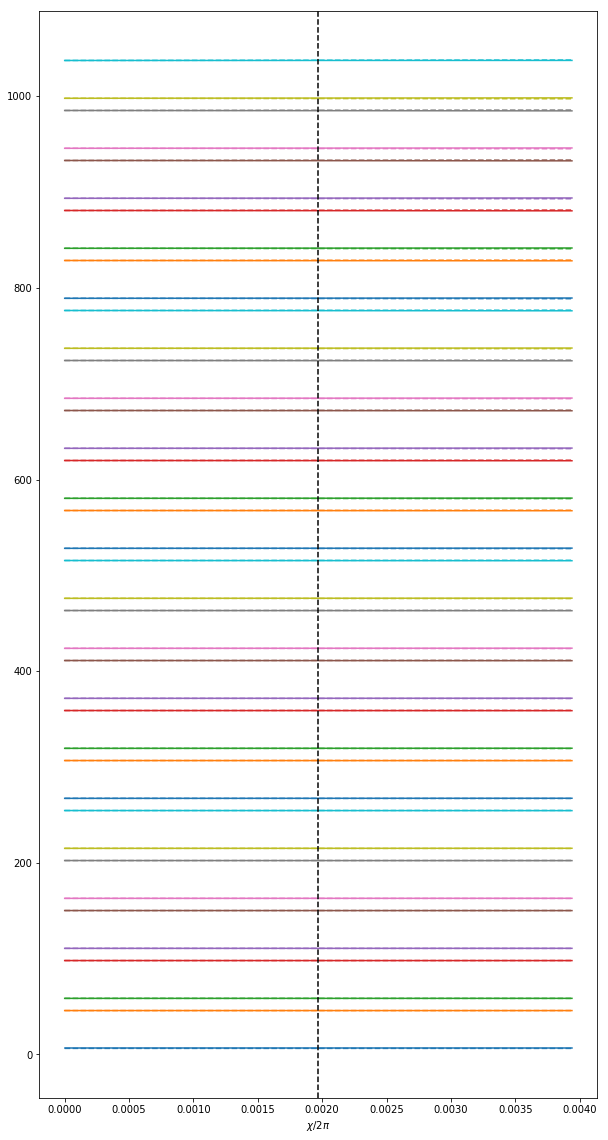

In [780]:
def hamiltonian(wr, wq, chi, dis = False):
    if dis:
        H = wr * (a.dag() * a + I/2.0) + (wq / 2.0) * sz + chi * (a.dag() * a + I/2) * sz
    else:
        g = sqrt(abs(wr-wq) * chi)
        H = wr * (a.dag() * a + I/2.0) + (wq / 2.0) * sz + g*(a.dag() + a)*sx
    return H


chi_vec = np.linspace(0,2*chi,100)

energies = array([hamiltonian(wr,wq, chi_i, dis=True).eigenenergies() for chi_i in chi_vec])
eigs = np.zeros((energies.shape[1], energies.shape[0]))
for i, x in enumerate(energies):
    for j, x in enumerate(energies[0]):
        eigs[j][i] = energies[i,j]       
fig, axes = plt.subplots(1,1, figsize=(10,20))
for i in range(len(eigs)):
    axes.plot(chi_vec/(2*pi), eigs[i], '--');

energies = array([hamiltonian(wr,wq, chi_i, dis=False).eigenenergies() for chi_i in chi_vec])
eigs = np.zeros((energies.shape[1], energies.shape[0]))
for i, x in enumerate(energies):
    for j, x in enumerate(energies[0]):
        eigs[j][i] = energies[i,j]   
for i in range(len(eigs)):
    axes.plot(chi_vec/(2*pi), eigs[i]);
axes.axvline(x=chi_vec[-1]/(4*pi), linestyle='--', color='k');
axes.set_xlabel('$\\chi/2\\pi$');

Try different initial state of the resonator, and see how the spectrum further down in the notebook reflects the photon distribution chosen here.

In [781]:
#psi0 = tensor(coherent(N, sqrt(6)), (basis(2,0)+basis(2,1)).unit())

In [782]:
#psi0 = tensor(thermal_dm(N, 3), ket2dm(basis(2,0)+basis(2,1))).unit()

In [783]:
psi0 = tensor(coherent(N, sqrt(4)), (basis(2,0)+basis(2,1)).unit())

## Time evolution

In [784]:
tlist = np.linspace(0, 250*t_fac, 1000)

In [785]:
H = hamiltonian(wr,wq, chi, dis=False)
res = mesolve(H, psi0, tlist, [], [], options=Odeoptions(nsteps=5000), progress_bar=True)

10.0%. Run time:   4.48s. Est. time left: 00:00:00:40
20.0%. Run time:   8.81s. Est. time left: 00:00:00:35
30.0%. Run time:  13.22s. Est. time left: 00:00:00:30
40.0%. Run time:  17.80s. Est. time left: 00:00:00:26
50.0%. Run time:  22.10s. Est. time left: 00:00:00:22
60.0%. Run time:  26.31s. Est. time left: 00:00:00:17
70.0%. Run time:  30.50s. Est. time left: 00:00:00:13
80.0%. Run time:  34.75s. Est. time left: 00:00:00:08
90.0%. Run time:  38.91s. Est. time left: 00:00:00:04
Total run time:  43.00s


### Excitation numbers

We can see that the systems do not exchange any energy, because of they are off resonance with each other.

In [786]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

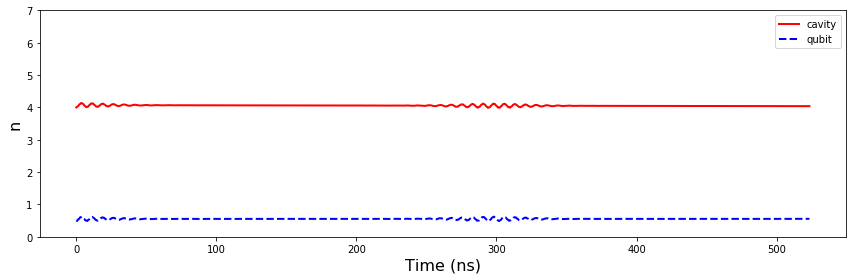

In [787]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, nc_list, 'r', linewidth=2, label="cavity")
ax.plot(tlist, nq_list, 'b--', linewidth=2, label="qubit")
ax.set_ylim(0, 7)
ax.set_ylabel("n", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

### Resonator quadrature

However, the quadratures of the resonator are oscillating rapidly.

In [788]:
xc_list = expect(xc, res.states)
yc_list = expect(yc, res.states)

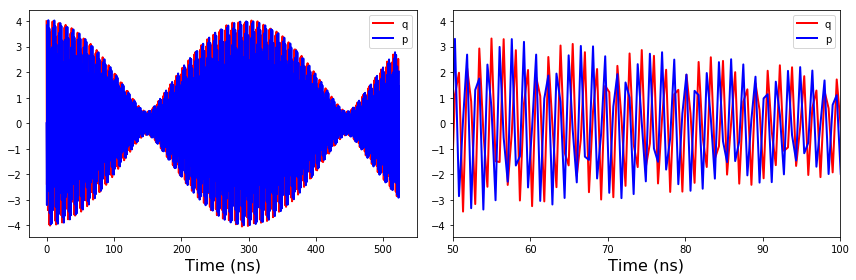

In [789]:
fig, [ax,ax2] = plt.subplots(1,2,sharex=False, figsize=(12,4))

ax.plot(tlist, xc_list, 'r', linewidth=2, label="q")
ax.plot(tlist, yc_list, 'b', linewidth=2, label="p")
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

ax2.plot(tlist, xc_list, 'r', linewidth=2, label="q")
ax2.plot(tlist, yc_list, 'b', linewidth=2, label="p")
ax2.set_xlabel("Time (ns)", fontsize=16)
ax2.set_xlim(50,100)
ax2.legend()
fig.tight_layout()

### Correlation function for the resonator

In [790]:
tlist = np.linspace(0, 1000*t_fac, 10000)

In [791]:
corr_vec = correlation(H, psi0, None, tlist, [], a.dag(), a)

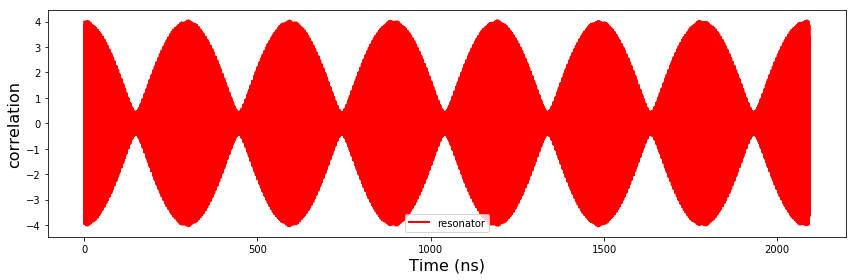

In [796]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, np.real(corr_vec), 'r', linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
#ax.set_xlim(0,50)
fig.tight_layout()

### Spectrum of the resonator

In [793]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

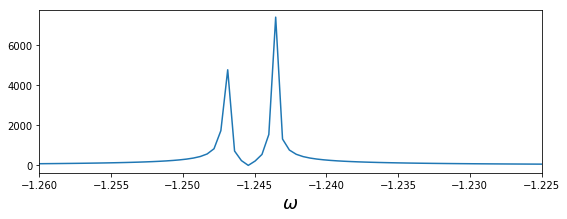

In [804]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
#ax.set_xlim(wr/(2*pi)-.5, wr/(2*pi)+.5);
ax.set_xlim(-1.26, -1.225);

Here we can see how the resonator peak is split and shiften up and down due to the superposition of 0 and 1 states of the qubit! We can also verify that the splitting is exactly $2\chi$, as expected:

Text(0.5, 0, '$(\\omega-\\omega_r)/\\chi$')

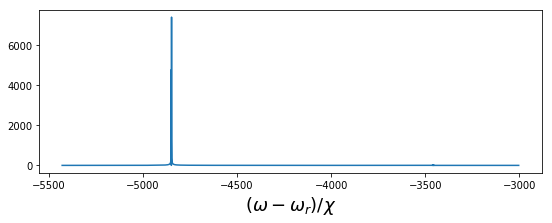

In [799]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w-wr)/chi, abs(S))
ax.set_xlabel(r'$(\omega-\omega_r)/\chi$', fontsize=18)
ax.set_xlim(-2,2);

### Correlation function of the qubit

In [ ]:
corr_vec = correlation(H, psi0, None, tlist, [], sx, sx)

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, real(corr_vec), 'r', linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,50)
fig.tight_layout()

### Spectrum of the qubit

The spectrum of the qubit has an interesting structure: from it one can see the photon distribution in the resonator mode!

In [ ]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

In [ ]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)

It's a bit clearer if we shift the spectrum and scale it with $2\chi$

In [ ]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w - wq - chi) / (2 * chi), abs(S))
ax.set_xlabel(r'$(\omega - \omega_q - \chi)/2\chi$', fontsize=18)
ax.set_xlim(-.5, N);

Compare to the cavity fock state distribution:

In [ ]:
rho_cavity = ptrace(res.states[-1], 0)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N)-.4, real(rho_cavity.diag()), color="blue", alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel('Fock number', fontsize=12)
axes.set_ylabel('Occupation probability', fontsize=12);

And if we look at the cavity wigner function we can see that after interacting dispersively with the qubit, the cavity is no longer in a coherent state, but in a superposition of coherent states.

In [ ]:
plot_wigner(rho_cavity);

### Software versions

In [ ]:
from qutip.ipynbtools import version_table
version_table()